In [1]:
# Dependency
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import tqdm

from PIL import Image

COLORS = [
    (255, 0, 0),   # red
    (0, 255, 0),  # green
    (0, 0, 255),   # blue
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
]

In [2]:
import cv2
def load(image_path):
    image = cv2.imread(image_path)
    h, w, c = image.shape
    image_np = np.float32(image)
    # TODO: please normalize image_pixl using Z-score
    _mean = image_np.mean().mean()
    _std = np.sum(image_np - _mean).sum() / (h * w)
    image_norm = (image - _mean) / _std
    image_norm = image_norm.reshape(h * w, -1)
    print(image_norm.shape)
    
    return h, w, c, image_norm

In [3]:
def kmeans(n_cluster, image_pixl):
    kmeans = KMeans(n_clusters=n_cluster)# instantiate a K-means
    labels = kmeans.fit_predict(image_pixl)# fit and get clustering result
    initial_mus = kmeans.cluster_centers_# get centroids
    initial_priors, initial_covs = [], []
    #Followings are for initialization:
    for i in range(n_cluster):
        datas = image_pixl[labels == i, ...].T
        initial_covs.append(np.cov(datas))
        initial_priors.append(datas.shape[1] / len(labels))
    print(np.shape(initial_mus), np.shape(initial_priors), np.shape(initial_covs))
    return initial_mus, initial_priors, initial_covs

In [22]:
class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        """
        :param ncomp:           the number of clusters
        :param initial_mus:     initial means
        :param initial_covs:    initial covariance matrices
        :param initial_priors:  initial mixing coefficients
        """
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas):
        """
        E-step
        :param datas:   original data
        :return:        posterior probability (gamma) and log likelihood
        """
        probs = []
        # print(self.mus)
        # print(self.covs)
        # print(self.priors)
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov, allow_singular=True)
            probs.append(np.expand_dims(prob, -1))
        preds = np.concatenate(probs, axis=1)

        # TODO: calc log likelihood
        N = np.shape(preds)[0]
        log_likelihood = (np.log(np.sum(preds, axis = 1)))

        # TODO: calc gamma
        gamma = preds / np.sum(preds, axis=1)[:,None]

        return gamma, log_likelihood

    def update(self, datas, gamma):
        """
        M-step
        :param datas:   original data
        :param gamma:    gamma
        :return:
        """
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(gamma, axis=0)
        for i in range(self.ncomp):
            # TODO: calc mu
            new_mu = (datas.T @ gamma[:,i]).T / soft_counts[i]
            #print("mu shape:", np.shape(new_mu), new_mu)
            new_mus.append(new_mu)

            # TODO: calc cov
            new_cov = np.cov(datas.T, aweights=gamma[:,i])
            #print("cov shape:", np.shape(new_cov), new_cov)
            new_covs.append(new_cov)

            # TODO: calc mixing coefficients
            new_prior = soft_counts[i] / np.shape(gamma)[0]
            new_priors.append(new_prior)
            #print("prior shape:", np.shape(new_prior), new_prior)

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)

    def fit(self, data, iteration):
        prev_log_liklihood = None

        bar = tqdm.tqdm(total=iteration)
        for i in range(iteration):
            #print("go inference")
            gamma, log_likelihood = self.inference(data)
            #print("end inference")
            self.update(data, gamma)
            if prev_log_liklihood is not None and abs(log_likelihood - prev_log_liklihood) < 1e-10:
                break
            prev_log_likelihood = log_likelihood

            bar.update()
            bar.set_postfix({"log likelihood": log_likelihood})

In [23]:
from PIL import Image
import matplotlib.pyplot as plt


def visualize(gmm, image, ncomp, ih, iw):
    beliefs, log_likelihood = gmm.inference(image)
    map_beliefs = np.reshape(beliefs, (ih, iw, ncomp))
    segmented_map = np.zeros((ih, iw, 3))
    for i in range(ih):
        for j in range(iw):
            hard_belief = np.argmax(map_beliefs[i, j, :])
            segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
    plt.imshow(segmented_map)
    plt.show()

(187308, 3)
(187308, 3)
(3, 3) (3,) (3, 3, 3)
GMM begins...















  0%|          | 1/500 [00:00<02:05,  3.97it/s, log likelihood=[-43.40122827 -43.62883174 -43.84870837 ... -41.08682159 -41.03007047




  0%|          | 2/500 [00:00<01:59,  4.16it/s, log likelihood=[-43.40122827 -43.62883174 -43.84870837 ... -41.08682159 -41.03007047




  0%|          | 2/500 [00:00<01:59,  4.16it/s, log likelihood=[-43.57788636 -43.38510435 -45.1724703  ... -41.05102113 -40.94387153




  1%|          | 3/500 [00:00<01:57,  4.23it/s, log likelihood=[-43.57788636 -43.38510435 -45.1724703  ... -41.05102113 -40.94387153




  1%|          | 3/500 [00:00<01:57,  4.23it/s, log likelihood=[-43.57804866 -43.23232283 -46.39522213 ... -41.13541318 -40.8974294




  1%|          | 4/500 [00:00<02:00,  4.12it/s, log likelihood=[-43.57804866 -43.23232283 -46.39522213 ... -41.13541318 -40.8974294




  1%|          | 4/500 [00:00<02:00,  4.12it/s, log likelihood=[-43.78456722 -43.32524358 -45.80801769 ... -41.53739503 -41.01555819




  1%|          | 5/500 [00:01<

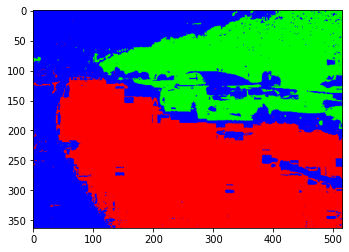

Finish!


In [24]:
ih, iw, ic, image_norm = load("data/original/sample.png")
print(image_norm.shape)
ncomp = 3
iteration=500
# init mu, prior and cov
initial_mus, initial_priors, initial_covs = kmeans(ncomp, image_norm)

# GMM
print("GMM begins...")
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)
gmm.fit(image_norm, iteration)

# visualize
visualize(gmm, image_norm, ncomp, ih, iw)
print("Finish!")

1. It is a unsupervised method and does not require data labeling, and with covariance matrix it can form elliptical boundaries which is more flexible than k-means.
2. It is very sensitive to outliers.
3. If the data are clearly seperated by elliptical boundaries, GMM clustering is suitable for fitting this data set.